In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Projects/LSTM/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import string, re
from string import digits
from numpy import array, argmax, random, take
import pandas as pd

from keras_self_attention import SeqSelfAttention
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, RepeatVector, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [2]:
def read_data(file_name="fra.txt"):
    data_path = f"{file_name}"
    df = pd.read_table(data_path, names=['source', 'target', 'comments'])
    df = df.drop(['comments'], axis = 1) 
    return df

In [3]:
df = read_data()
print(df.shape)
df.head()

(178009, 2)


,source,target
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [4]:
examples = 75000
df = df[:examples]
print(df.shape)
df.head()

(75000, 2)


,source,target
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


# Preprocess

In [5]:
def preprocess(df):
    # convert source and target text to Lowercase
    df.source = df.source.apply(lambda x: x.lower())
    df.target = df.target.apply(lambda x: x.lower())
    
    # creating a space between a word and the punctuation following it
    df.source = df.source.apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))
    df.target = df.target.apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))
    
    df.source = df.source.apply(lambda x: re.sub(r'[" "]+', " ", x))
    df.target = df.target.apply(lambda x: re.sub(r'[" "]+', " ", x))
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    df.source = df.source.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))
    df.target = df.target.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))
    
    # Remove digits from source and target sentences
    num_digits = str.maketrans('', '', digits)
    df.source = df.source.apply(lambda x: x.translate(num_digits))
    df.target = df.target.apply(lambda x: x.translate(num_digits))
    
    # Remove extra spaces
    df.source = df.source.apply(lambda x: x.strip())
    df.target = df.target.apply(lambda x: x.strip())
    df.source = df.source.apply(lambda x: re.sub(" +", " ", x))
    df.target = df.target.apply(lambda x: re.sub(" +", " ", x))

    # Add start and end tokens to target sequences
    df.target = df.target.apply(lambda x: 'START_ ' + x + ' _END')
    
    return df

In [6]:
df = preprocess(df)
df.head()

,source,target
0,go .,START_ va ! _END
1,hi .,START_ salut ! _END
2,hi .,START_ salut . _END
3,run !,START_ cours ! _END
4,run !,START_ courez ! _END


# Tokenization

In [7]:
def tokenization(data, maxlen = 100):
    token = Tokenizer(lower=True, oov_token='oov')
    token.fit_on_texts(data)
    
    data_seq = token.texts_to_sequences(data)
    data_pad = pad_sequences(data_seq, maxlen=maxlen, padding='post')
    
    return token, data_pad

In [8]:
maxlen = 50
token_src, tensor_src = tokenization(df['source'], maxlen)
token_trg, tensor_trg = tokenization(df['target'], maxlen)

In [9]:
# prepare english tokenizer
eng_tokenizer =token_src
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = maxlen
print('Size of English Vocabulary : %d' % eng_vocab_size)

# prepare Hindi tokenizer
hin_tokenizer = token_trg
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = maxlen
print('Size of Hindi Vocabulary : %d' % hin_vocab_size)

Size of English Vocabulary : 7292
Size of Hindi Vocabulary : 11300


# Glove and Embedding Matrix

In [13]:
# creating glove vectors
def get_glove_vector():
    glove_vectors = {}

    with open("glove.6B.100d.txt", "r", encoding="UTF-8") as glove:
        for line in glove:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:])
            glove_vectors[word] = vectors
    return glove_vectors

glove_vectors = get_glove_vector()
total_words = len(glove_vectors.keys()) 
total_words

400000

In [14]:
emb_dim = 100

# create word vector matrix with glove vectors
def create_word_vector_matrix(token, glove_vectors, vocab_size, emb_dim):
    word_vector_matrix = np.zeros((vocab_size, emb_dim))
    
    count = 0
    for word, index in token.word_index.items():
        vector = glove_vectors.get(word)
        if vector is not None:
            word_vector_matrix[index] = vector
        else:
            count += 1
    print(f"Vector not found for {count} words")
    return word_vector_matrix

In [15]:
emb_matrix_src = create_word_vector_matrix(token_src, glove_vectors, eng_vocab_size, emb_dim)
emb_matrix_trg = create_word_vector_matrix(token_trg, glove_vectors, hin_vocab_size, emb_dim)

Vector not found for 13 words
Vector not found for 7048 words


# Model

In [25]:
model_name = "models/"+"GRU Attention.h5"

modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

callback_list = [modelcheckpoint, lr_callback]


model = Sequential()
model.add(Embedding(eng_vocab_size, 100, input_length=eng_length, mask_zero=True, weights=[emb_matrix_src]))
model.add(Bidirectional(GRU(512, return_sequences=True)))

model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))

# model.add(RepeatVector(hin_length))
model.add(Bidirectional(GRU(512, return_sequences=True)))
# model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(Dense(hin_vocab_size, activation='softmax'))
 
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           729200    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 50, 1024)          1886208   
_________________________________________________________________
Attention (SeqSelfAttention) (None, 50, 1024)          65601     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50, 1024)          4724736   
_________________________________________________________________
dense_3 (Dense)              (None, 50, 11300)         11582500  
Total params: 18,988,245
Trainable params: 18,988,245
Non-trainable params: 0
_________________________________________________________________


In [26]:
print(tensor_src.shape, tensor_trg.shape)

(75000, 50) (75000, 50)


In [27]:
history = model.fit(tensor_src, tensor_trg, epochs=10, batch_size=32, validation_split=0.2, callbacks=callback_list, shuffle=True)

Epoch 1/10


KeyboardInterrupt: 

# Inference

In [26]:
reverse_word_index_src = {v: k for k, v in token_src.word_index.items()}
reverse_word_index_trg = {v: k for k, v in token_trg.word_index.items()}

In [59]:
def simplify(perdicted_tensor):
  string = ''
  for i in perdicted_tensor:
    word = reverse_word_index_trg.get(i)
    if word is not None:
      string += word + ' '
    # print(i, string)
  string = string.split(" ")[1:-2]
  ans = ''
  for j in string:
    ans += j + " "
  return ans[:-1]

In [67]:
res = model.predict_classes(tensor_src[50:51])

In [68]:
res = simplify(list(res[0]))
res

'je suis parti'

In [69]:
df['source'][50:51]

50    i left .
Name: source, dtype: object

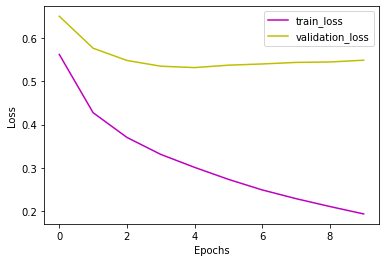

In [70]:
plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='y')
plt.legend(['train_loss', 'validation_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

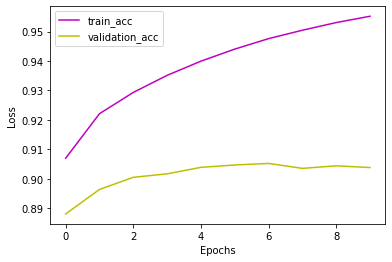

In [72]:
plt.plot(history.history['accuracy'], c='m')
plt.plot(history.history['val_accuracy'], c='y')
plt.legend(['train_acc', 'validation_acc'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()